In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("train1.csv",encoding="ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Columns: 686 entries, id to Unnamed: 685
dtypes: float64(24), object(662)
memory usage: 86.0+ MB


In [4]:
df.isnull().sum()

id               3607
title            5047
author           6325
text             5688
label            5917
                ...  
Unnamed: 681    16425
Unnamed: 682    16425
Unnamed: 683    16425
Unnamed: 684    16425
Unnamed: 685    16425
Length: 686, dtype: int64

In [6]:
df.describe()

,Unnamed: 524,Unnamed: 529,Unnamed: 534,Unnamed: 539,Unnamed: 543,Unnamed: 556,Unnamed: 561,Unnamed: 564,Unnamed: 565,Unnamed: 566,...,Unnamed: 601,Unnamed: 607,Unnamed: 612,Unnamed: 617,Unnamed: 621,Unnamed: 625,Unnamed: 654,Unnamed: 675,Unnamed: 683,Unnamed: 685
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1992.0,1992.0,1992.0,1992.0,1992.0,1972.0,1990.0,183.0,187.0,194.0,...,1992.0,1975.0,1975.0,1975.0,1977.0,1979.0,1977.0,1986.0,1991.0,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1992.0,1992.0,1992.0,1992.0,1992.0,1972.0,1990.0,183.0,187.0,194.0,...,1992.0,1975.0,1975.0,1975.0,1977.0,1979.0,1977.0,1986.0,1991.0,1.0
25%,1992.0,1992.0,1992.0,1992.0,1992.0,1972.0,1990.0,183.0,187.0,194.0,...,1992.0,1975.0,1975.0,1975.0,1977.0,1979.0,1977.0,1986.0,1991.0,1.0
50%,1992.0,1992.0,1992.0,1992.0,1992.0,1972.0,1990.0,183.0,187.0,194.0,...,1992.0,1975.0,1975.0,1975.0,1977.0,1979.0,1977.0,1986.0,1991.0,1.0
75%,1992.0,1992.0,1992.0,1992.0,1992.0,1972.0,1990.0,183.0,187.0,194.0,...,1992.0,1975.0,1975.0,1975.0,1977.0,1979.0,1977.0,1986.0,1991.0,1.0
max,1992.0,1992.0,1992.0,1992.0,1992.0,1972.0,1990.0,183.0,187.0,194.0,...,1992.0,1975.0,1975.0,1975.0,1977.0,1979.0,1977.0,1986.0,1991.0,1.0


In [8]:
# Drop completely empty rows
df.dropna(how='all', inplace=True)

# Drop rows with missing values in required columns
df.dropna(subset=['text', 'label'], inplace=True)

# Remove duplicates
df.drop_duplicates(subset='text', inplace=True)

# Ensure labels are either 0 or 1
df = df[df['label'].isin([0, 1])]

# Convert label to integer
df['label'] = df['label'].astype(int)

columns = ['text', 'label']
df = df[columns]

In [9]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
df.describe()

,label
count,72.000000
mean,0.500000
std,0.503509
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [11]:
# Clean Text
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)              # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_text'] = df['text'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_text
16350,President Donald J. Trumpâs admiration for A...,0,president donald j trumps admiration andrew ja...
16351,âInvisible Nation: Homeless Families in Amer...,1,invisible nation homeless families america boo...
16352,It just goes to show you that you can't rely o...,1,goes show cant rely fire extinguisher let go b...
16353,0 comments \nMore and more evidence is surfaci...,1,comments evidence surfacing hillary clinton cr...
16354,VIDEO : New Powerful Trump ad Targets Hindu an...,1,video new powerful trump ad targets hindu indi...


In [12]:
# Feature Extraction using TF-IDF with n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, min_df=5, max_features=10000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']


In [13]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [14]:
# XGBoost with Hyperparameter Tuning
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

grid = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False), params, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
model = grid.best_estimator_


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Accuracy: 0.8
Precision: 0.75
Recall: 0.8571428571428571
F1 Score: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.75      0.86      0.80         7

    accuracy                           0.80        15
   macro avg       0.80      0.80      0.80        15
weighted avg       0.81      0.80      0.80        15



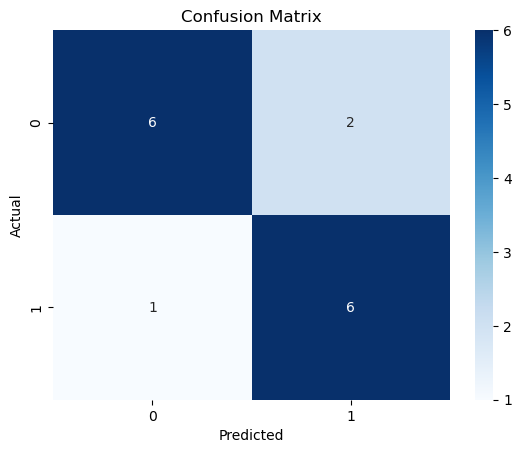

In [15]:
# Model Evaluation
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Cross-Validation for Stability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print("Cross-Validation F1 Scores:", f1_scores)
print("Average F1 Score:", np.mean(f1_scores))


Cross-Validation F1 Scores: [0.63157895 0.82352941 0.8        0.85714286 0.93333333]
Average F1 Score: 0.8091169099218634


In [17]:
import joblib

# Save the trained model
joblib.dump(model, 'model.pkl')

# Save the fitted vectorizer (e.g., TfidfVectorizer)
joblib.dump(vectorizer, 'vectorizer.pkl')


['vectorizer.pkl']